ME200, Johannes Ruf and Luitgard Veraart

# Day 12: Case study and implied volatilities

In this worksheet we will be providing a case study for pricing a cash-or-nothing call option using different methods. 

Furthermore, we will be analysing the concept of implied volatilities in the Black-Schole model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
rng = np.random.default_rng(seed=22446688)

## Pricing a cash-or-nothing call option in the Black-Scholes model

Consider the following European digital option with payoff at maturity $T$ given by 
\begin{align*}
L \mathbf{1}_{\{S_T \geq K\}}, 
\end{align*}
where $K, L > 0$ and the indicator $\mathbf{1}_{\{S_T \geq K\}}$ is 1 if $S_T \geq K$ and 0 otherwise. Hence, this is a European option on $S_T$ that pays nothing if at the maturity date $S_T < K$ and otherwise it pays $L$. 
What is its time-0 price? 

In the lecture notes we have seen that its time-$0$ price is given by 
\begin{align*}
V_0 &=  L e^{-rT} \Phi(D_1 - \sigma \sqrt{T}), 
\end{align*}

We implement this formula below. 

In [2]:
def cash_or_nothing_call(S0, L, K, r, T, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = L * np.exp(-r * T) * norm.cdf(d2, loc=0, scale=1)
    return price

Next, we compute the price using a Monte Carlo estimator and an Antithetic Variates estimator. We start with the Monte Carlo estimator. We re-use the function terminal_stockprice from the previous notebook. This funtion generates a sample of termial stock prices in the Black-Scholes model. 

In [3]:
def terminal_stockprice(rng, S0, T, r, sigma, samplesize):
    mystandardnormalsample = rng.standard_normal(size=samplesize)
    tmp1 = (r - 0.5*(sigma ** 2)) * T
    tmp2 = sigma * np.sqrt(T) * mystandardnormalsample
    stockprice = S0 * np.exp(tmp1 + tmp2)
    return stockprice

Next, we write a function that compute a Monte Carlo estimate together with a confidence interval for the time-$0$ price of a cash-or nothing option. 

In [4]:
def bs_cashnothingcall_mc(rng, S0, L, K, T, r, sigma, samplesize, myepsilon):
    # Generate terminal stock prices.
    mystockprice = terminal_stockprice(rng, S0, T, r, sigma, samplesize)
    # Compute payoffs.
    payoffs = np.zeros(samplesize)
    payoffs[(mystockprice > K)] = L
    # Discount payoffs
    discountedpayoffs = np.exp(- r * T)*payoffs
    # Compute MC price
    price = np.mean(discountedpayoffs)
    # Compute confidence interval next
    standarddev_rv = np.std(discountedpayoffs, ddof=1)
    standarddev_mcest = standarddev_rv / np.sqrt(samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = price - aepsilon * standarddev_mcest
    # Right boundary of CI
    ci_right = price + aepsilon * standarddev_mcest
    return price, standarddev_mcest, ci_left, ci_right

In the following we provide some illustration what happens in line 3-6 in the function above: 

In [5]:
mystockprice = terminal_stockprice(rng, S0=100, T=1, r=0.01, sigma=0.2, samplesize=10)
payoffs = np.zeros(10)
payoffs[(mystockprice > 100)] = 5
print((mystockprice > 100))
print(payoffs)

[ True False False  True False  True  True False False  True]
[5. 0. 0. 5. 0. 5. 5. 0. 0. 5.]


Next, we consider the antithetic variate estimator. We can re-use the function that generates the terminal stock price using pairs $(X, -X)$ where $X \sim N(0, 1)$ from the previous notebook. 

In [6]:
def terminal_stockprice_av(rng, S0, T, r, sigma, halfsamplesize):
    """Function computes terminal stock prices based on antithetic pairs. """
    mynormals1 = rng.standard_normal(halfsamplesize)
    mynormals2 = - mynormals1
    tmp1 = (r - 0.5*sigma ** 2) * T
    tmp2 = sigma * np.sqrt(T) * mynormals1
    tmp3 = sigma * np.sqrt(T) * mynormals2
    stockprice1 = S0 * np.exp(tmp1 + tmp2)
    stockprice2 = S0 * np.exp(tmp1 + tmp3)
    allstockprices = np.concatenate((stockprice1, stockprice2))
    return stockprice1, stockprice2, allstockprices

Next, we write a function that computes an antithetic variates estimate together with a confidence interval for the cash-or-nothing call option in the Black-Scholes model. 

In [7]:
def bs_cashnothingcall_av(rng, S0, L, K, T, r, sigma, halfsamplesize, myepsilon):
    """ Antithethic variate estimation for European call price in BS model."""
    # Note that 2*halfsamplesize random variables will be used in the AV estimator.
    # Generate terminal stock prices.
    mystockprices = terminal_stockprice_av(rng, S0, T, r, sigma, halfsamplesize)
    # Compute payoffs.
    payoffs1 = np.zeros(halfsamplesize)
    payoffs1[(mystockprices[0] > K)] = L
    payoffs2 = np.zeros(halfsamplesize)
    payoffs2[(mystockprices[1] > K)] = L
    
    # Discount payoffs
    discpayoffs1 = np.exp(- r * T)*payoffs1
    discpayoffs2 = np.exp(- r * T)*payoffs2
    thecov = np.cov(discpayoffs1, discpayoffs2, ddof=1)[0, 1]
    possiblereduction = thecov / (2 * halfsamplesize)
    discpayoffs = np.concatenate((discpayoffs1, discpayoffs2))
    price = np.mean(discpayoffs)
    standarddev_rv = np.std(discpayoffs, ddof=1)
    standarddev_avest = standarddev_rv / np.sqrt(2 * halfsamplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    ci_left = price - aepsilon * standarddev_avest
    ci_right = price + aepsilon * standarddev_avest
    return price, standarddev_avest, ci_left, ci_right, possiblereduction

Finally, we consider a specific example by choosing some model parameters. We compute the time-$0$ price of the cash-or-nothing European call option in the Black-Scholes model using the analytical formula, a Monte Carlo estimator and an antithetic variates estimator. 

In [8]:
# Defining some model parameters
S0 = 100.0
K = 100.0
L = 100.0
T = 1.0
r = 0.0
sigma = 0.3
halfsamplesize = 100000
samplesize = 2 * halfsamplesize 
myepsilon = 0.05
mydig = 8

print('----------------')
print('The analytical option price is {:.4f}'.format(cash_or_nothing_call(S0, L, K, r, T, sigma)))
print('-----------------')
MCresults = bs_cashnothingcall_mc(rng, S0, L, K, T, r, sigma, samplesize, myepsilon)
print('MC price: {:.4f} stdev of MC est: {:.4f}'.format(MCresults[0], MCresults[1]))
print('CI based on MC is ({:.4f}, {:.4f})'.format(MCresults[2], MCresults[3]))

print('----------------')
AVresults = bs_cashnothingcall_av(rng, S0, L, K, T, r, sigma, halfsamplesize, myepsilon)
print('AV price: {:.4f} and stdev of AV est: {:.4f}'.format(AVresults[0], AVresults[1]))
print('CI based on AV is ({:.4f}, {:.4f})'.format(AVresults[2], AVresults[3]))
print('Note that sample covariance/(2n) is {:.4f}'.format(AVresults[4]))

----------------
The analytical option price is 44.0382
-----------------
MC price: 44.0145 stdev of MC est: 0.1110
CI based on MC is (43.7969, 44.2321)
----------------
AV price: 44.0330 and stdev of AV est: 0.1110
CI based on AV is (43.8154, 44.2506)
Note that sample covariance/(2n) is -0.0097


We see that both estimates are close to the analytical option price. The antithetic variates estimator has a slightly smaller variance than the Monte Carlo estimator for the chosen parameters. 

Next, we will consider implied volatilies in the Black-Scholes market.  

## Black-Scholes option pricing formula for European call option
We will first provide an implementation of the Black-Scholes option pricing formula for a European Call option. 

Recall that the time-t price of a European call option with strike $K$ and maturity $T$ in the Black-Scholes model is given by
\begin{align*}
C_t = S_t \Phi(d_1) - K e^{-r(T-t)} \Phi(d_2), 
\end{align*}
where $S_t$ denotes the stock price at time $t$, $r > 0$ is the riskless interest rate, $\sigma > 0$ is the volatility of the stock price and
\begin{align*}
d_1 & = \frac{\log(\frac{S_t}{K}) + (r + 0.5 \sigma^2)(T-t) }{\sigma \sqrt{T-t}}, \\
d_2 & = d_1 - \sigma \sqrt{T-t}.  
\end{align*}

In the following we will set $\tau=T-t$. Then, $\tau$ is the time left until the contract expires. 

In [9]:
def black_scholes_call(S, K, r, tau, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    tmp1 = S * norm.cdf(d1, loc=0, scale=1)
    tmp2 = K * np.exp(-r * tau) * norm.cdf(d2, loc=0, scale=1)
    price = tmp1 - tmp2
    return price


myprice = black_scholes_call(S=50, K=50, r=0.05, tau=1.0, sigma=0.3)
print('Price of European call option is: {:.4f}'.format(myprice))

Price of European call option is: 7.1156


In [10]:
def bs_vega(S, K, r, tau, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau)/(sigma * np.sqrt(tau))
    vega = S * np.sqrt(tau) * norm.pdf(d1, loc=0, scale=1)
    # print("d1=", d1)
    return vega

myvega = bs_vega(S=50, K=50, r=0.05, tau=1.0, sigma=0.3)
print('Vega = {:.4f}'.format(myvega))

Vega = 18.9716


In [11]:
def find_impliedvol_Newton(S, K, r, tau, marketprice, initialguess):
    sigmaold = initialguess
    maxiteration = 100
    mydiff = 1
    for i in range(maxiteration):
            callprice = black_scholes_call(S, K, r, tau, sigmaold)
            vega = bs_vega(S, K, r, tau, sigmaold)
            if (vega < 0.000000001):
                # print("problem: i= ", i, "sigmaold = ", sigmaold, "callprice= ", callprice, "and vega = ", vega)
                return "Error in vega"
            else: 
                sigmanew =  sigmaold - (callprice - marketprice) / vega
                mydiff = np.abs(sigmaold - sigmanew)
                sigmaold = sigmanew
            
            if (mydiff < 0.0000001): 
                return sigmaold
    return "Max iteration reached"


myprice = black_scholes_call(S=50, K=50, r=0.05, tau=1.0, sigma=0.3)
print('Price of European call option is: {:.4f}'.format(myprice))
myimpliedvol= find_impliedvol_Newton(S=50, K=50, r=0.05, tau=1.0, marketprice=7.11562739299, initialguess=0.8)
print('Implied vol is {:.4f}'.format(myimpliedvol))

Price of European call option is: 7.1156
Implied vol is 0.3000


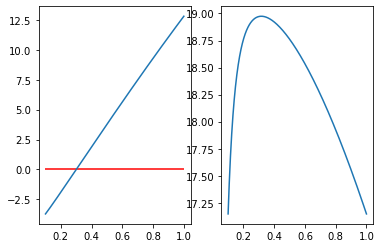

In [12]:
numberofsteps = 1000
sigmas = np.linspace(start=0.1, stop=1, num=numberofsteps)
pricediff = np.zeros(numberofsteps)
vegas = np.zeros(numberofsteps)

for i in range (numberofsteps): 
    pricediff[i] = black_scholes_call(S=50, K=50, r=0.05, tau=1, sigma=sigmas[i]) - 7.11562739299 
    vegas[i] = bs_vega(S=50, K=50, r=0.05, tau=1, sigma=sigmas[i])
   
    
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(sigmas, pricediff)
axs[0].hlines(0, xmin=sigmas[0], xmax=sigmas[-1], color="red")
axs[1].plot(sigmas, vegas);

### Stylised example for implied volatilities

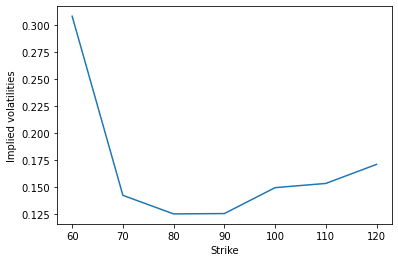

In [13]:
teststrikes = np.array([60, 70, 80, 90, 100, 110, 120])
testprices = np.array([22, 11, 4, 1, 0.4, 0.1, 0.05])
S0=80
testimpliedvols1 = np.zeros(7)


# Computing implied volatities  
for i in range(teststrikes.size):
    testimpliedvols1[i] = find_impliedvol_Newton(S=S0, K=teststrikes[i], r=0, tau=1, marketprice=testprices[i], initialguess=0.5)
    
# Plotting implied volatilities   
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(teststrikes, testimpliedvols1)
ax.set_xlabel("Strike")
ax.set_ylabel("Implied volatilities"); 

#fig.savefig("Smile1.pdf")

### Case study of implied volatilities

In the following we consider some data of call option prices.
Assume the data were observed on 13/06/2022  and the maturity date is 24th June 2022. 
The price of the stock on 13/06/2022 is 137.13 USD. 

In [14]:
strikes = np.linspace(start=133, stop=150, num=(150-133+1))
strikes = np.concatenate((np.array([125, 130]), strikes), axis=None)
callprices = np.array([13.23, 8.9, 6.7, 6.25, 5.35, 4.71, 4.15, 3.64, 3.15, 2.7, 2.34, 1.96, 1.67, 1.42, 1.14, 0.94, 0.8, 0.65, 0.52, 0.43])


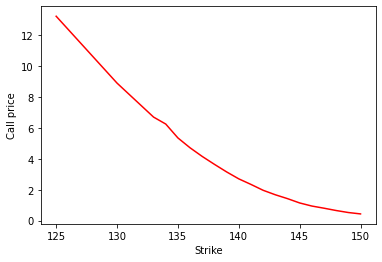

In [15]:
fix, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(strikes, callprices, color="red")
ax.set_xlabel("Strike")
ax.set_ylabel("Call price");

We see, that the market prices of the call option prices are decreasing in the strike price.   

Next, we compute the corresponding implied volatilities. 

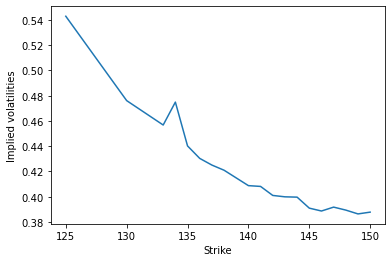

In [16]:
impliedvols = np.zeros(strikes.size)

# Computing implied volatities corresponding to the longer maturity    
for i in range(strikes.size):
    impliedvols[i] = find_impliedvol_Newton(S=137.13, K=strikes[i], r=0, tau=11/356, marketprice=callprices[i], initialguess=0.5)
    
# Plotting implied volatilities   
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(strikes, impliedvols)
ax.set_xlabel("Strike")
ax.set_ylabel("Implied volatilities");

We observe an overall skew pattern. Here,  $S_0=137.13$.  